In [228]:
from multiprocessing import Pool
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [229]:
def arrangement_1(nleds,d):
    l=math.sqrt(nleds);
    ledcord=np.zeros((2,nleds));
    temp=0;
    for k in range(nleds):
        ledcord[0,k]=-(l-1)*d/2 +((k)%l)*d;
        if (k)%l ==0 and k != 0:
            temp=temp+1;
        ledcord[1,k]=-(l-1)*d/2 + temp*d;
    return ledcord
    
def E_r(ledcord,nleds,Ir_0,z,d,r):    
    x=r;
    y=0;
    E=0;
    for i in range(nleds):
        den=np.square(np.square(x-ledcord[0,i]) +np.square(y-ledcord[1,i]) +z**2);
        E= E + (z**2 * Ir_0)*(np.reciprocal(den))
    return E

def bin_search(ledcord,nleds,Ir_0,z,d,r_arr, r_lo, r_up, E_req):
    r_mid=(r_up+r_lo)//2 
    if E_r(ledcord,nleds,Ir_0,z,d,r_arr[r_mid-1])> E_req and E_r(ledcord,nleds,Ir_0,z,d,r_arr[r_mid])<= E_req:
        return r_arr[r_mid]
    
    elif E_r(ledcord,nleds,Ir_0,z,d,r_arr[r_mid])> E_req and E_r(ledcord,nleds,Ir_0,z,d,r_arr[r_mid-1])> E_req:
        return bin_search(ledcord,nleds,Ir_0,z,d,r_arr,r_mid,r_up,E_req)
    
    else:
        return bin_search(ledcord,nleds,Ir_0,z,d,r_arr, r_lo, r_mid, E_req)
  

In [230]:
Ir_0 = 1;
final_list = []
r_arr = np.linspace(0,5,50001)
r_up=len(r_arr)-1
r_lo=0
def ratio(d):
    final_list = []
    for nleds in [9,25,49,81,121,169]:
        lled=np.sqrt(nleds)
        if((lled-1)*d>0.5):
            break
        else:     
            ledcord = arrangement_1(nleds,d)
            nz = (0.5 - d)/0.001 +1
            for z in np.linspace(d,0.5,nz):
                E_cent = E_r(ledcord,nleds,Ir_0,z,d,0)
                E_half = E_cent/2
                E_99 = E_cent * 0.99
                r_99 = bin_search(ledcord,nleds,Ir_0,z,d,r_arr, r_lo, r_up, E_99)
                r_half = bin_search(ledcord,nleds,Ir_0,z,d,r_arr, r_lo, r_up, E_half)
                final_list.append([nleds,d,z,E_cent,E_99, r_99,E_half,r_half])
    return final_list

with Pool(7) as p:
      l = list(tqdm(p.imap(ratio,np.linspace(0.01,0.2,181)), total=181))

100%|██████████| 181/181 [42:20<00:00, 14.04s/it]  


In [231]:
t=[]
for i in l:
    t.extend(i)
#     print(len(i))
final_list=t

In [232]:
df = pd.DataFrame(final_list,columns=["nleds","d","z","E_cent","E_99","r_99","E_half","r_half"])

In [233]:
df["ratio"]=df["r_99"]/df["r_half"]

In [234]:
len(df["E_99"].unique())

206467

In [235]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
# df

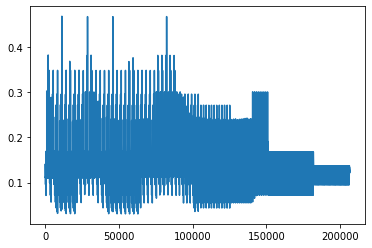

In [236]:
plt.plot(df["ratio"])

In [237]:
len(df["ratio"].unique())

110990

In [241]:
idx = df.groupby(['nleds'])['ratio'].transform(max) == df['ratio']
df[idx][df[idx]["nleds"] != 1].sort_values("nleds")

,nleds,d,z,E_cent,E_99,r_99,E_half,r_half,ratio
5886,9,0.012111,0.018122,12263.004503,12140.374458,0.0029,6131.502252,0.0205,0.141463
6375,25,0.012111,0.019124,16325.797645,16162.539669,0.0054,8162.898822,0.0317,0.170347
982,49,0.010000,0.010000,30340.617441,30037.211267,0.0106,15170.308721,0.0350,0.302857
10273,81,0.013167,0.017174,17050.142384,16879.640960,0.0162,8525.071192,0.0595,0.272269
1964,121,0.010000,0.010000,31446.255515,31131.792960,0.0210,15723.127758,0.0549,0.382514
11243,169,0.013167,0.013167,18269.997766,18087.297789,0.0400,9134.998883,0.0854,0.468384
